# HW2 Overview

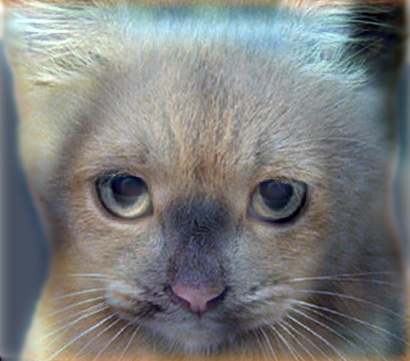

(Does this look like the same animal from closeup and far away?)

The goal of this assignment is to write an image filtering function and use it to create hybrid images using a simplified version of the SIGGRAPH 2006 [paper](https://stanford.edu/class/ee367/reading/OlivaTorralb_Hybrid_Siggraph06.pdf) by Oliva, Torralba, and Schyns. Hybrid images are static images that change in interpretation as a function of the viewing distance. The basic idea is that high frequency tends to dominate perception when it is available, but, at a distance, only the low frequency (smooth) part of the signal can be seen. By blending the high-frequency portion of one image with the low-frequency portion of another, you get a hybrid image that leads to different interpretations at different distances.

## Guidelines
- **AI Assistance**: You are allowed to use AI tools to assist you with this assignment. However, you must explicitly acknowledge and summarize your AI usage in the **"AI Usage Summary"** section at the end of the assignment.
- **Autograding**: The assignment will be autograded upon submission to Gradescope. To ensure the autograding process works correctly:
  - Do not delete or rename any pre-defined functions and variables.
  - Replace the `...` placeholders with your implementations.
  - Ensure all inputs and outputs strictly adhere to the formats specified in the problem descriptions.
  - You are allowed to add additional print statements or visualizations to help with debugging. However, ensure these do not interfere with the functionality of the main function or required outputs.
- **Submission**: Submit the completed `.ipynb` file to Gradescope.

# Details

This project is intended to familiarize you with image filtering. Once you understand the basic tools for loading, manipulating, and filtering images, it is relatively straightforward to construct hybrid images.

**Image Filtering**. Image filtering (or convolution) is a fundamental image processing tool. See chapter 3.2 of Szeliski and the lecture materials to learn about image filtering (specifically linear filtering). MATLAB and Python have numerous built-in and efficient functions to perform image filtering (try searching for imfilter or conv2d or convolve and fspecial).

**Hybrid Images**. A hybrid image is the sum of a low-pass filtered version of the one image and a high-pass filtered version of a second image. There is a free parameter, which can be tuned for each image pair, which controls how much high frequency to remove from the first image and how much low frequency to leave in the second image. This is called the "cutoff-frequency". In the paper, it is suggested to use two cutoff frequencies (one tuned for each image) and you are free to try that, as well.

We provide you with 5 pairs of aligned images which you must merge to construct hybrid images (these should all work reasonably well for some cut-off frequency). The alignment is important because it affects the perceptual grouping (read the paper for details). In addition, you must create at least two different examples (e.g. change of expression, morph between different objects, change over time, etc.) using image pairs you find. See their [paper](https://stanford.edu/class/ee367/reading/OlivaTorralb_Hybrid_Siggraph06.pdf) for some inspiration.

For the example shown at the top of the page, the two original images look like this:

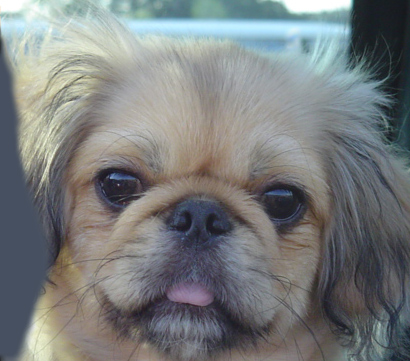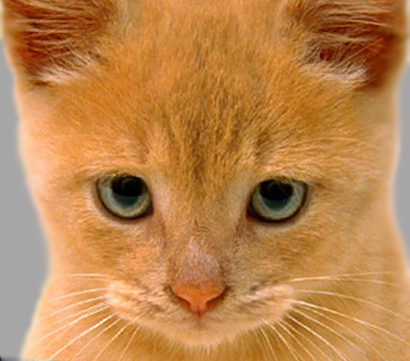

The low-pass (blurred) and high-pass versions of these images look like this:

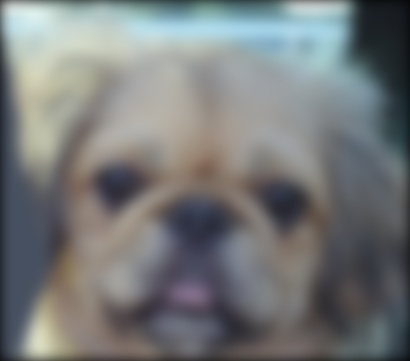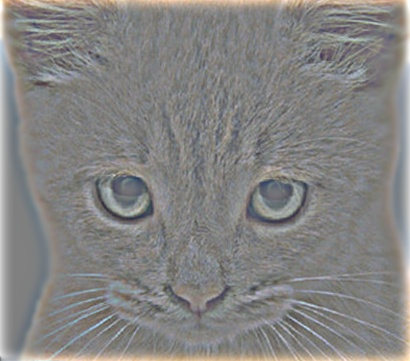

The high-frequency image is actually zero-mean with negative values so it is visualized by adding 0.5. In the resulting visualization, bright values are positive and dark values are negative.

Adding the high and low frequencies together gives you the image at the top of this page. If you're having trouble seeing the multiple interpretations of the image, a useful way to visualize the effect is by progressively downsampling the hybrid image as is done below:

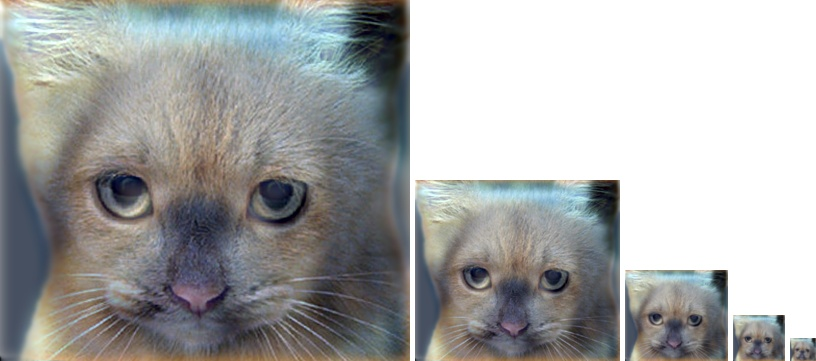

Assuming you have downloaded data and made it ready to be accessed by this notebook, let's proceed to implementing our approach for creating cool hybrid images!

# Implementation
#### **Note**: Unless specified, do not use additional packages or built-in functions for achieving the filtering operations.

In [1]:
# Importing Packages
import numpy as np
from imageio.v2 import imread
from skimage.transform import resize, warp, AffineTransform
import matplotlib.pyplot as plt
from skimage import filters
%matplotlib inline

In [2]:
# Reading Images
def read_image(path):
  img = imread(path)
  return img

One of the commonly used filters in image processing is gaussian kernel. Read the [paper](https://stanford.edu/class/ee367/reading/OlivaTorralb_Hybrid_Siggraph06.pdf) to learn how gaussian kernels can be used as both high pass filter as well as low pass filter. Making an assumption of $\mu=0$, a 2D-gaussian filter parametrized by Ïƒ can be represented by equation below:

G(x, y) = $\frac{1}{2 \pi \sigma^2} exp(-\frac{(x^2+y^2)}{2\sigma^2})$

**Hint**: Try using larger kernel sizes and sigma values.

In [3]:
# Constructing Gaussian Kernel Matrix
def get_gaussian_kernel(ksize=3, mu=0, sigma=1):
  """
  Create a 2D Gaussian kernel matrix.

  Args:
      ksize: Kernel size (int, should be odd). The kernel will be (ksize, ksize).
      mu: Mean of the Gaussian distribution (float, typically 0).
      sigma: Standard deviation of the Gaussian in pixels (float, controls blur strength).

  Returns:
      np.ndarray: A (ksize, ksize) Gaussian kernel matrix, normalized to sum to 1.
  """
  # Code Goes Here:
  #######################################
  ax = np.linspace(-(ksize // 2), ksize // 2, ksize)

  x, y = np.meshgrid(ax, ax)

  g = np.exp(-(x**2 + y**2) / (2 * sigma**2))

  gauss_kernel = g / np.sum(g)

  #######################################
  return gauss_kernel


In [4]:
def test1_public(get_gaussian_kernel):
    kernel = get_gaussian_kernel(ksize=5, mu=0, sigma=2)
    assert kernel.shape == (5, 5), "Kernel shape should be (ksize, ksize)"
    assert np.isclose(kernel.sum(), 1.0), "Kernel should sum to 1"
    assert kernel[2, 2] == kernel.max(), "Center should be the maximum value"
    print("Kernel shape, normalization, and center OK")

test1_public(get_gaussian_kernel)

Kernel shape, normalization, and center OK


**Hint**: We expect the output of convolution to be the same size and shape as that of the input. For that, you would need to use padding. For padding, look at the function `numpy.pad`

**Hint**: Filter needs to be applied on each channel separately.

In [5]:
# Convolution Operation
def convolve(img, kernel):
  """
  Convolve an image with a kernel using edge padding.

  Args:
      img: Input image array of shape (H, W, C) where C is the number of channels.
      kernel: 2D kernel array of shape (K, K) where K is the kernel size.

  Returns:
      np.ndarray: Convolved image with same shape as input (H, W, C).
  """
  # Code Goes Here:
  #######################################
  h, w, c = img.shape
  ksize = kernel.shape[0]
  pad_size = ksize // 2

  convolved_img = np.zeros_like(img)

  image_pad = np.pad(img, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='constant')

  kernel_flip = kernel[::-1, ::-1]

  for i in range(h):
    for j in range(w):
      for k in range(c):
        convolved_img[i, j, k] = np.sum(image_pad[i:i+ksize, j:j+ksize, k] * kernel_flip)

  #######################################
  return convolved_img


In [8]:
def test2_public(convolve, get_gaussian_kernel):
    img = np.random.random((16, 16, 3))
    kernel = get_gaussian_kernel(ksize=3, sigma=1)
    result = convolve(img, kernel)
    assert result.shape == img.shape, "Output shape should match input shape"
    print("Output shape OK")

# test2_public(convolve, get_gaussian_kernel)


Output shape OK


**Visualize the effect of convolving images**

In [50]:
# Provide path for pair of images
path11 = "inputs/1a.bmp"
path21 = "inputs/1a.bmp"
path12 = "inputs/2b.bmp"
path22 = "inputs/2a.bmp"
path13 = "inputs/3b.bmp"
path23 = "inputs/3a.bmp"
path14 = "inputs/4b.bmp"
path24 = "inputs/4a.bmp"
path15 = "inputs/5b.bmp"
path25 = "inputs/5a.bmp"

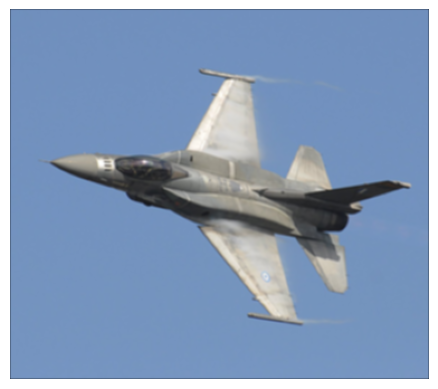

In [51]:
# Visualize a convolved image
def plot_conv_img(img, ksize=3, mu=0, sigma=1):
  img = img / 255
  gauss_kernel = get_gaussian_kernel(ksize,mu,sigma)
  cnv_img = convolve(img, gauss_kernel)
  plt.imshow(np.clip(cnv_img,a_min=0,a_max=1))
  plt.axis('off')
  plt.show()

ksize=3; mu=0; sigma=1
path = path12

img = read_image(path)
plot_conv_img(img, ksize, mu, sigma)

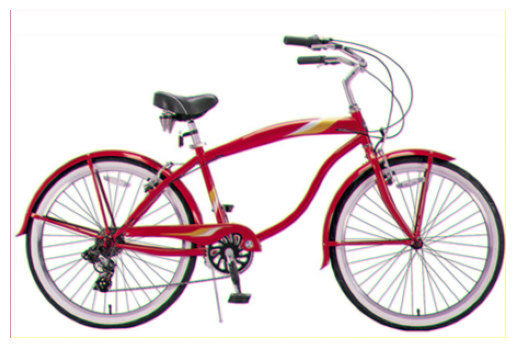

In [15]:
# Convolve an image differently across each channel
# before recombining back into one image and visualizing
def conv_img_by_channel(img, ksizes=[1,2,3], mus=[0,0,0], sigmas=[1,2,3]):
  """
  Apply different Gaussian filters to each color channel.

  Args:
      img: Input image array of shape (H, W, 3) with 3 color channels.
      ksizes: List of 3 kernel sizes, one per channel.
      mus: List of 3 mu values, one per channel.
      sigmas: List of 3 sigma values, one per channel.

  Returns:
      np.ndarray: Filtered image of shape (H, W, 3) with each channel filtered independently.
  """
  # Code Goes Here:
  #######################################
  cnv_img = np.zeros_like(img)

  for i in range(3):
    kernel = get_gaussian_kernel(ksizes[i], mus[i], sigmas[i])
    cnv_img[:, :, i: i + 1] = convolve(img[:, :, i: i + 1], kernel)

  #######################################
  return cnv_img

def plot_conv_img_by_channel(img, ksizes=[1,2,3], mus=[0,0,0], sigmas=[1,2,3]):
  img = img / 255
  cnv_img = conv_img_by_channel(img, ksizes, mus, sigmas)
  plt.imshow(np.clip(cnv_img,a_min=0,a_max=1))
  plt.axis('off')
  plt.show()

ksizes=[1,2,3]; mus=[0,0,0]; sigmas=[1,2,3]
path = path11

img = read_image(path)
plot_conv_img_by_channel(img, ksizes, mus, sigmas)


In [16]:
def test3_public(conv_img_by_channel):
    img = np.random.random((16, 16, 3))
    result = conv_img_by_channel(img, ksizes=[3,3,3], mus=[0,0,0], sigmas=[1,2,3])
    assert result.shape == img.shape, "Output shape should match input shape"
    print("Output shape OK")

test3_public(conv_img_by_channel)

Output shape OK


In [17]:
# Implement high pass filter and get edges of image
def hpf_filter(img, ksize=3, mu=0, sigma=1):
  """
  Apply a high-pass filter to extract edges/high-frequency components.

  The high-pass filter is computed as: original - low_pass(original)

  Args:
      img: Input image array of shape (H, W, C).
      ksize: Kernel size for the Gaussian filter (int, should be odd).
      mu: Mean of the Gaussian distribution (float, typically 0).
      sigma: Standard deviation of the Gaussian in pixels (float).

  Returns:
      np.ndarray: High-frequency image of shape (H, W, C). Values may be negative.
  """
  # Code Goes Here:
  #######################################
  kernel = get_gaussian_kernel(ksize, mu, sigma)
  low_pass = convolve(img, kernel)
  hpf_img = img - low_pass

  #######################################
  return hpf_img


In [18]:
def test4_public(hpf_filter):
    img = np.random.random((16, 16, 3))
    result = hpf_filter(img, ksize=3, sigma=1)
    assert result.shape == img.shape, "Output shape should match input shape"
    # High-pass output should have mean close to 0 (removes DC component)
    assert np.abs(result.mean()) < np.abs(img.mean()), "HPF should reduce mean intensity"
    print("Output shape and high-pass behavior OK")

test4_public(hpf_filter)

Output shape and high-pass behavior OK


In [19]:
# Implement low pass filter and get blurred image
def lpf_filter(img, ksize=3, mu=0, sigma=1):
  """
  Apply a low-pass (Gaussian) filter to blur the image.

  Args:
      img: Input image array of shape (H, W, C).
      ksize: Kernel size for the Gaussian filter (int, should be odd).
      mu: Mean of the Gaussian distribution (float, typically 0).
      sigma: Standard deviation of the Gaussian in pixels (float).

  Returns:
      np.ndarray: Blurred image of shape (H, W, C).
  """
  # Code Goes Here:
  #######################################
  kernel = get_gaussian_kernel(ksize, mu, sigma)
  lpf_img = convolve(img, kernel)

  #######################################
  return lpf_img


In [20]:
def test5_public(lpf_filter):
    img = np.random.random((16, 16, 3))
    result = lpf_filter(img, ksize=5, sigma=2)
    assert result.shape == img.shape, "Output shape should match input shape"
    # Low-pass should reduce variance (smoothing)
    assert result.var() <= img.var(), "LPF should reduce variance (smoothing)"
    print("Output shape and low-pass behavior OK")

test5_public(lpf_filter)

Output shape and low-pass behavior OK


In [21]:
# Decompose image into low and high frequency components
def analyze_frequency_components(img, ksize=3, sigma=3):
  """
  Decompose an image into low and high frequency components.

  This function demonstrates that an image can be perfectly reconstructed
  by adding its low-frequency and high-frequency components.

  Args:
      img: Input image array of shape (H, W, C) with values in [0, 1].
      ksize: Kernel size for Gaussian filter (int, should be odd).
      sigma: Standard deviation of Gaussian in pixels (float).

  Returns:
      dict with keys:
      - 'low_freq': Low-pass filtered image, shape (H, W, C).
      - 'high_freq': High-pass filtered image, shape (H, W, C).
      - 'reconstruction': low_freq + high_freq, shape (H, W, C).
  """
  # Code Goes Here:
  #######################################
  low_freq = lpf_filter(img, ksize=ksize, sigma=sigma)
  high_freq = hpf_filter(img, ksize=ksize, sigma=sigma)
  reconstruction = low_freq + high_freq

  #######################################
  return {
      'low_freq': low_freq,
      'high_freq': high_freq,
      'reconstruction': reconstruction
  }


In [22]:
def test6_public(analyze_frequency_components):
    img = np.random.random((8, 8, 3))
    result = analyze_frequency_components(img, ksize=3, sigma=2)

    assert isinstance(result, dict), "Must return a dictionary"
    assert 'low_freq' in result, "Missing 'low_freq' key"
    assert 'high_freq' in result, "Missing 'high_freq' key"
    assert 'reconstruction' in result, "Missing 'reconstruction' key"
    assert result['low_freq'].shape == img.shape, "low_freq shape mismatch"
    assert result['high_freq'].shape == img.shape, "high_freq shape mismatch"
    assert result['reconstruction'].shape == img.shape, "reconstruction shape mismatch"
    print("Structure and shapes OK")

test6_public(analyze_frequency_components)

Structure and shapes OK


In [23]:
def plot_img(img_1, img_2):
    # Plot the images side by side
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    axes[0].imshow(np.clip(img_1,a_min=0,a_max=1))
    axes[0].axis('off')
    axes[0].set_title('Blurred Image')

    axes[1].imshow(np.clip(img_2,a_min=0,a_max=1))
    axes[1].axis('off')
    axes[1].set_title('Edge Image')

In [24]:
# Plot resized images
def plot_resize_imgs(img):
  fig, axs = plt.subplots(1, 5, figsize=(15, 10), gridspec_kw={'width_ratios':[20, 15, 10, 5, 1]})
  fig.tight_layout()
  for i in range(5):
    axs[i].imshow(np.clip(img,a_min=0,a_max=1))
    axs[i].axis('off')
  plt.show()

In [25]:
# Compute hybrid image from 2 given images using your functions
def get_hybrid_img(im1, im2, ksize=3, mu=0, sigma=1):
  """
  Create a hybrid image by combining low frequencies from im1 with high frequencies from im2.

  Args:
      im1: First input image of shape (H, W, C), values in [0, 1]. Used for low frequencies.
      im2: Second input image of shape (H, W, C), values in [0, 1]. Used for high frequencies.
      ksize: Kernel size for the Gaussian filter (int, should be odd).
      mu: Mean of the Gaussian distribution (float, typically 0).
      sigma: Standard deviation of the Gaussian in pixels (float). Controls cutoff frequency.

  Returns:
      np.ndarray: Hybrid image of shape (H, W, C).
  """
  # Code Goes Here:
  #######################################
  blurred_img = lpf_filter(im1, ksize=ksize, sigma=sigma)
  edge_img = hpf_filter(im2, ksize=ksize, sigma=sigma)
  hybrid_img = blurred_img + edge_img


  #######################################
  plot_img(blurred_img, edge_img+0.5)
  return hybrid_img


In [26]:
def test7_public(get_hybrid_img):
    import contextlib, io
    im1 = np.random.random((16, 16, 3))
    im2 = np.random.random((16, 16, 3))
    with contextlib.redirect_stdout(io.StringIO()):
        result = get_hybrid_img(im1, im2, ksize=3, sigma=2)
        plt.close()
    assert result.shape == im1.shape, "Output shape should match input shape"
    print("Output shape OK")

test7_public(get_hybrid_img)

Output shape OK


### Comparing the hybrid images generated through built-in functions and the functions you wrote

In [32]:
# Provide path for pair of images
path11 = "1b.bmp"
path21 = "1a.bmp"
path12 = "2b.bmp"
path22 = "2a.bmp"
path13 = "3b.bmp"
path23 = "3a.bmp"
path14 = "4b.bmp"
path24 = "4a.bmp"
path15 = "5b.bmp"
path25 = "5a.bmp"

In [33]:
# Hybrid Image generated using built-in functions (Just one way to do it)
def get_hybrid_img_builtin(im1, im2, ksize=3, mu=0, sigma=1):

  blurred_img = filters.gaussian(im1, sigma=sigma)
  edge_img = im2 - filters.gaussian(im2, sigma=sigma)
  hybrid_img = blurred_img + edge_img

  # END SOLUTION

  #######################################
  plot_img(blurred_img, edge_img+0.5)
  # plot_img(edge_img + 0.5, "Edge img")
  return hybrid_img

In [34]:
# Main Function
def main(path1, path2, filter_type='baseline', ksize=3, mu=0, sigma=1):
  """
  Load two images and create a hybrid image.

  Args:
      path1: Path to first image (will be low-pass filtered).
      path2: Path to second image (will be high-pass filtered).
      ksize: Kernel size for Gaussian filter.
      mu: Mean of Gaussian.
      sigma: Standard deviation of Gaussian in pixels.
  """
  im1 = imread(path1) / 255
  im2 = imread(path2) / 255
  if filter_type == 'baseline':
    hybrid_img = get_hybrid_img(im1, im2, ksize=ksize, mu=mu, sigma=sigma)
  else:
    hybrid_img = get_hybrid_img_builtin(im1, im2, ksize=ksize, mu=mu, sigma=sigma)
  plot_resize_imgs(hybrid_img)


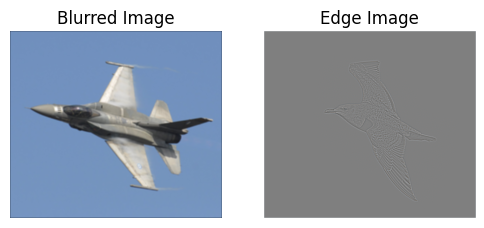

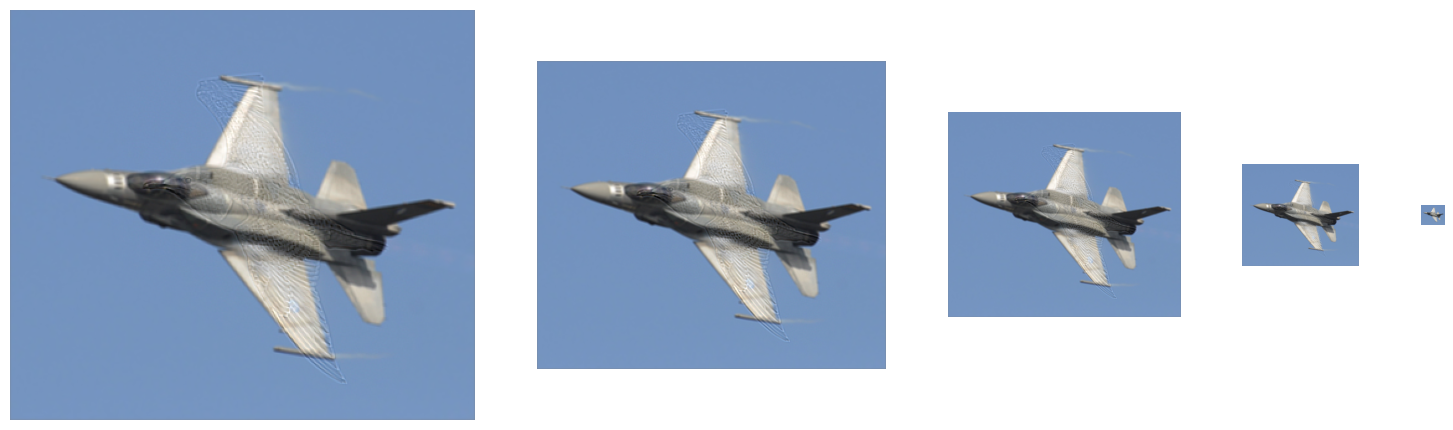

In [36]:
ksize=3; mu=0; sigma=3
main('inputs/'+path12, 'inputs/'+path22, 'baseline', ksize=ksize, mu=mu, sigma=sigma)

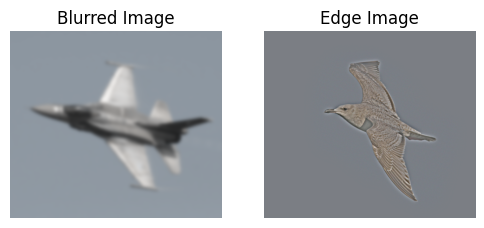

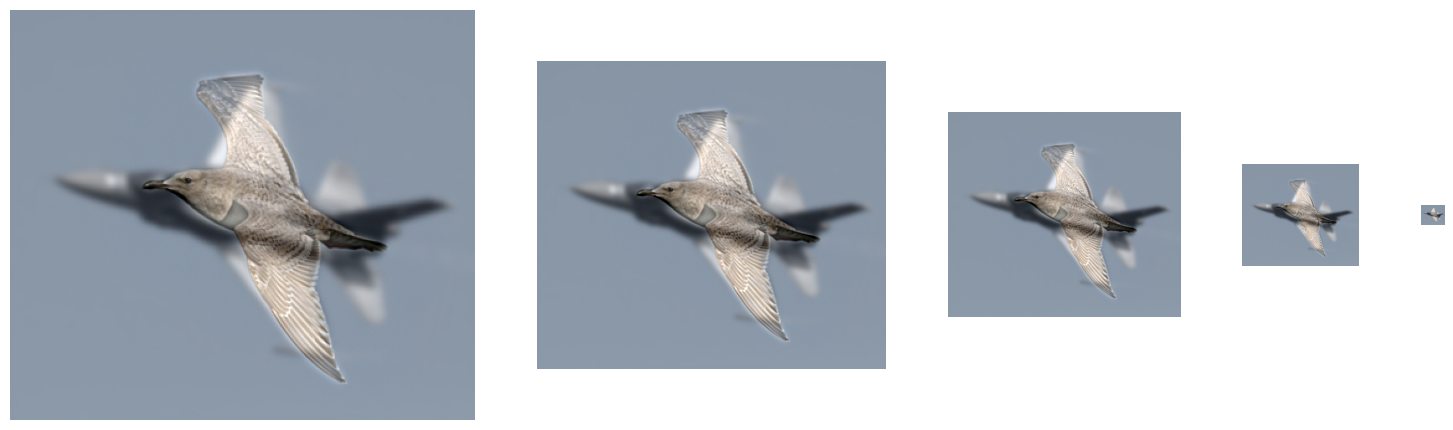

In [37]:
ksize=3; mu=0; sigma=3
main('inputs/'+path12, 'inputs/'+path22, 'nobaseline', ksize=ksize, mu=mu, sigma=sigma)

### Transforming image alignment to improve hybrid images

Here, you will be using skimage to scale, rotate, and translate one of the two images used for creating hybrid images to get better alignment.
**Hint**: you should use [AffineTransform](https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.AffineTransform) and [warp](https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.warp).

In [40]:
# transform an image
# Note: leave padding parameters as default
def transform_image(img, scale=1, rotation=0, translation=[0,0]):
  """
  Apply an affine transformation (scale, rotation, translation) to an image.

  Args:
      img: Input image array of shape (H, W, C).
      scale: Scale factor (float). Values < 1 shrink, > 1 enlarge.
      rotation: Rotation angle in radians (float). Positive = counter-clockwise.
      translation: Translation as [tx, ty] in pixels (list of 2 floats).

  Returns:
      np.ndarray: Transformed image of shape (H, W, C).
  """
  # Code Goes Here:
  #######################################
  import skimage.transform as transform
  tform = transform.AffineTransform(scale=scale, rotation=rotation, translation=translation)
  transformed_img = transform.warp(img, tform)

  #######################################
  return transformed_img


In [41]:
def test8_public(transform_image):
    img = np.random.random((16, 16, 3))
    # Identity transform should preserve image (approximately)
    result = transform_image(img, scale=1, rotation=0, translation=[0,0])
    assert result.shape == img.shape, "Output shape should match input shape"
    print("Output shape OK")

test8_public(transform_image)

Output shape OK


In [44]:
# Main Function with transformed image 1
def main_transform(path1, path2, filter_type='baseline', ksize=3, mu=0, sigma=1, scale=1, rotation=0, translation=[0,0]):
  """
  Create a hybrid image with an optional affine transform applied to the first image.

  Args:
      path1: Path to first image (will be transformed, then low-pass filtered).
      path2: Path to second image (will be high-pass filtered).
      filter_type: 'baseline' to use custom functions, else use built-in.
      ksize: Kernel size for Gaussian filter.
      mu: Mean of Gaussian.
      sigma: Standard deviation of Gaussian in pixels.
      scale: Scale factor for transform.
      rotation: Rotation angle in radians.
      translation: Translation as [tx, ty] in pixels.
  """
  im1 = imread('inputs/' + path1) / 255
  im2 = imread('inputs/' + path2) / 255
  im1 = transform_image(im1, scale=scale, rotation=rotation, translation=translation)
  if filter_type == 'baseline':
    hybrid_img = get_hybrid_img(im1, im2, ksize=ksize, mu=mu, sigma=sigma)
  else:
    hybrid_img = get_hybrid_img_builtin(im1, im2, ksize=ksize, mu=mu, sigma=sigma)
  plot_resize_imgs(hybrid_img)


Now, explore creating hybrid images again while changing their alignment.


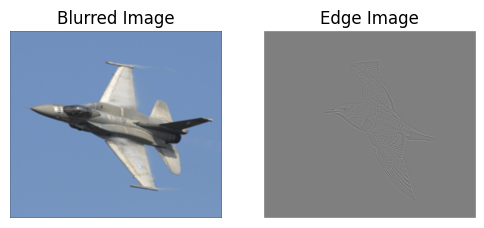

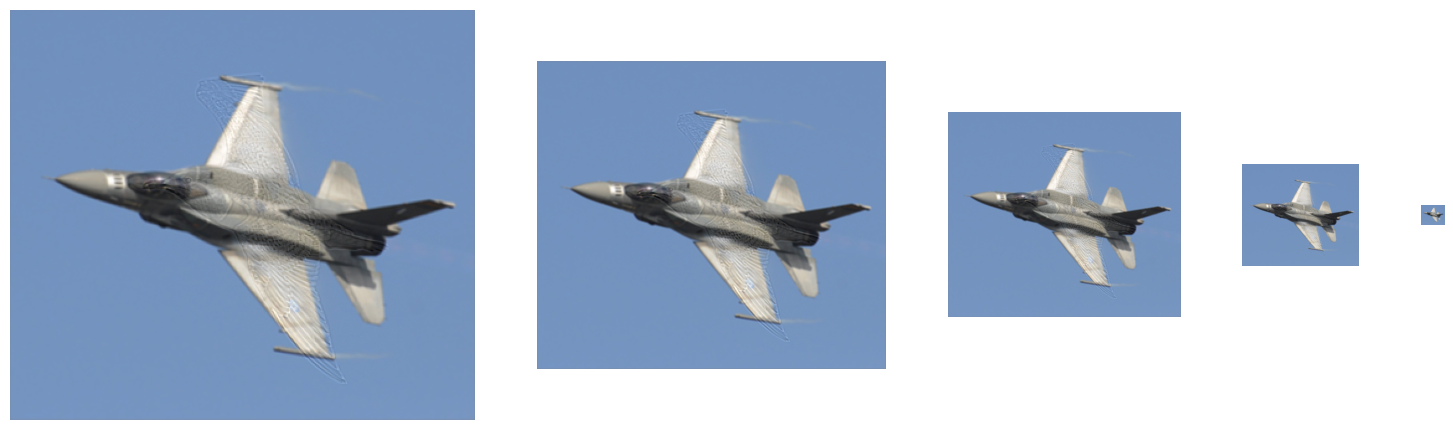

In [45]:
scale=1; rotation=0; translation=[0,0]
ksize=3; mu=0; sigma=1
main_transform(path12, path22, 'baseline',
     ksize=ksize, mu=mu, sigma=sigma,
     scale=scale, rotation=rotation, translation=translation
)

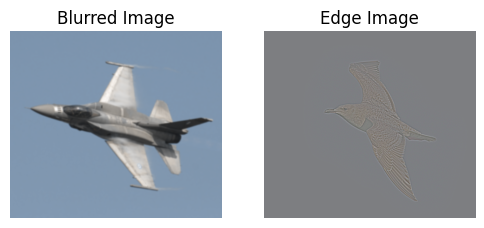

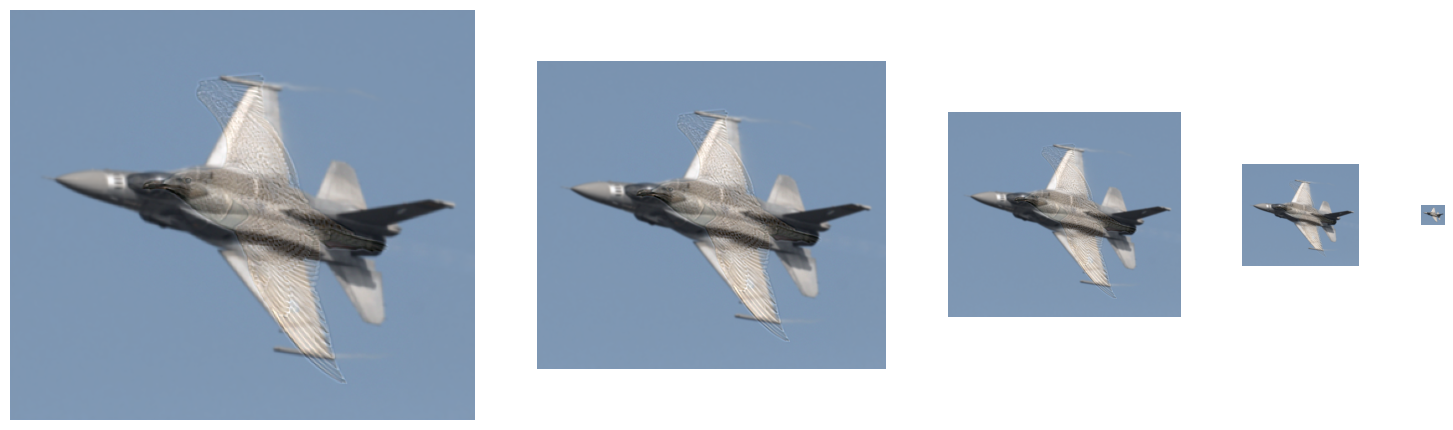

In [46]:
scale=1; rotation=0; translation=[0,0]
ksize=3; mu=0; sigma=1
main_transform(path12, path22, 'nobaseline',
     ksize=ksize, mu=mu, sigma=sigma,
     scale=scale, rotation=rotation, translation=translation
)

# Suggestions/Comments

1. **Kernel size matters**: When constructing a Gaussian filter, make sure that the kernel is large enough. If your kernel size is too small for your sigma value, the filter will behave like a Gaussian with a smaller sigma. A common rule of thumb is `ksize ≥ 6*sigma + 1`.

2. **Edge padding**: Your convolution function needs to handle image boundaries. The `np.pad` function with `mode="edge"` is a good default choice.

3. **Debugging tips**: If things aren't working, check array shapes at each step, and test on simple inputs (e.g., a 4x4 image with a 3x3 kernel) where you can verify the output by hand.

# Credits
Assignment developed by Nathan Jacobs based on a similar project by James Hays, which was based on a similar project by Derek Hoiem.

# AI Usage Summary

[as per course policy, we allow the use of AI assistants as part of completing homework assignments, however such usage must be acknowledged. If it is detected and not acknowledged, it will be considered a violation of academic integrity. As such, please summarize what AI tools you used to complete this assignment, including for understanding the concepts and generating source code. If you used code generation, please explain the extent to which you had to modify the solution for it to function correctly.]

- Fixing Dimension Errors: When processing channels individually, use img[:, :, i:i+1] instead of img[:, :, i] to keep the input 3D; this prevents the ValueError in your convolve function.
- Frequency Filtering: Remember that Low-pass is just blurring, while High-pass is the original image minus the low-pass version (Original - LPF).
- Hybrid Image Logic: Combine the Low-pass of Image A with the High-pass of Image B; use np.clip(result, 0, 1) to keep pixel values valid for display.
- Colab Path Handling: How Colab deal with the file path.